In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt 
from scipy.stats import gaussian_kde
sns.set(style="ticks",)
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline

## Load Data

In [76]:
df = pd.read_csv('../assets/results/results.csv')
seg_time = np.load(r"C:\Users\Jeremy\Documents\UMICH\Research\UnrealRooftopLanding\AirSimCollectData\LidarRoofManualTest\SegmentationInfer\timings.npy")
seg_time[0] = seg_time[1]

df['Segmentation'] = seg_time[:len(df)]
df['t_smoothing'] = df['t_laplacian'] + df['t_bilateral']
df['t_Polylidar3D'] = df['t_mesh'] + df['t_smoothing'] + df['t_fastga_total'] + df['t_polylidar_planepoly'] #+ df['t_polylidar_filter']
df.head()


,Unnamed: 0,uid,sub_uid,building,pl_base_iou,pl_seg_gt_iou,pl_seg_infer_iou,computer,t_laplacian,t_bilateral,...,t_fastga_integrate,t_fastga_peak,t_polylidar_planepoly,t_polylidar_filter,t_classify_pointcloud,t_polylabel,iou_diff,Segmentation,t_smoothing,t_Polylidar3D
0,0,0,0,Building7_Example4,0.939818,0.951617,0.951617,desktop,0.3703,0.4037,...,1.3170,3.2494,1.2993,1.9715,1.8246,0.0634,-0.011800,23.1339,0.7740,6.7969
1,1,0,1,Building7_Example4,0.943499,0.946554,0.946554,desktop,0.3276,0.4283,...,1.0961,2.5162,0.9292,1.7029,1.7209,0.0379,-0.003055,23.1339,0.7559,5.5145
2,2,1,0,Building7_Example4,0.888868,0.909375,0.909375,desktop,0.4025,0.4789,...,0.9339,2.9897,1.1585,2.7847,1.6968,0.0706,-0.020507,21.0637,0.8814,6.1709
3,3,1,1,Building7_Example4,0.893673,0.907671,0.907608,desktop,0.3311,0.4254,...,0.9552,2.8284,1.0772,2.8614,1.7140,0.0519,-0.013998,20.7461,0.7565,5.7869
4,4,2,0,Building7_Example4,0.939941,0.946661,0.946661,desktop,0.3819,0.7163,...,0.8580,3.0478,1.2062,2.0808,1.4961,0.0500,-0.006720,22.7534,1.0982,6.4119


## Specific IOUs
Here are some handpicked IOUs for some visualized examples in the paper

In [142]:
mask = (df['uid'] == 82) & (df['sub_uid'] == 1)
print(len(df))
df[mask]

328


,Unnamed: 0,uid,sub_uid,building,Polylidar3D,pl_seg_gt_iou,Semantic Polylidar3D,computer,t_laplacian,t_bilateral,...,t_fastga_integrate,t_fastga_peak,t_polylidar_planepoly,t_polylidar_filter,t_classify_pointcloud,t_polylabel,iou_diff,Segmentation,t_smoothing,t_Polylidar3D
153,153,82,1,Building9_Example,0.8642,0.908632,0.913379,desktop,0.3494,0.4082,...,1.1116,2.9678,1.0664,4.8963,1.7325,0.1263,-0.044432,21.3352,0.7576,6.1454


In [153]:
uids = df['uid'].to_numpy()
print(len(np.unique(uids)) / 5)
33 * 5 * 2

32.8


330

## Execution Time

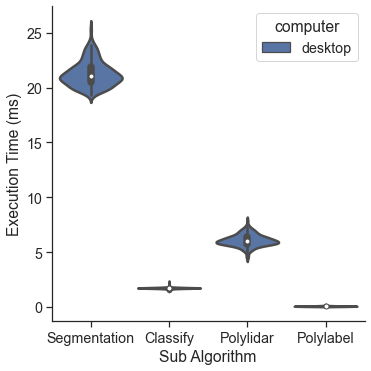

In [77]:
df_simple = df.rename(columns={"t_classify_pointcloud": "Classify", "t_Polylidar3D": "Polylidar", "t_polylabel": "Polylabel" })
df_simple = df_simple.melt(id_vars=["uid", "sub_uid", "computer"],
                                value_vars=['Segmentation','Classify', 'Polylidar', 'Polylabel'],
                                var_name="Sub Algorithm", 
                                value_name="Execution Time (ms)")
g = sns.catplot(data=df_simple, x='Sub Algorithm', hue='computer', y='Execution Time (ms)', kind='violin', legend_out=False)
g.savefig('../assets/imgs/alg_timings.pdf')

## Accuracy

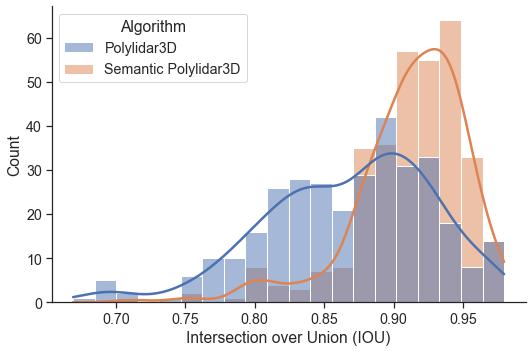

In [102]:
df = df.rename(columns={"pl_base_iou": "Polylidar3D", "pl_seg_infer_iou": "Semantic Polylidar3D"})
df_simple = df.melt(id_vars=["uid", "sub_uid"],
                                value_vars=['Polylidar3D', 'Semantic Polylidar3D'],
                                var_name="Algorithm", 
                                value_name="Intersection over Union (IOU)")
g = sns.displot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, facet_kws=dict(legend_out=False), aspect=1.5)
g.savefig('../assets/imgs/compare_algs.pdf')

In [128]:
palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

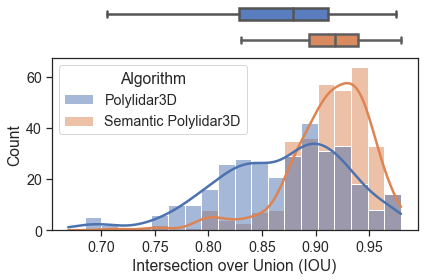

In [175]:
# Inspired from https://www.nature.com/articles/s41561-021-00693-5/figures/3
mask = df_simple['Algorithm'] == 'Polylidar3D'
df_baseline = df_simple[mask]
df_new = df_simple[~mask]
palette = sns.color_palette('muted', 2)
f, (ax_box_baseline, ax_box_new, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (0.075, 0.075, .85)})

g = sns.histplot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, ax=ax_hist, legend=True)

sns.boxplot(data=df_baseline, x="Intersection over Union (IOU)", ax=ax_box_baseline, color=palette[0], whis=None, showfliers=False)
sns.boxplot(data=df_new, x="Intersection over Union (IOU)", ax=ax_box_new, color=palette[1], whis=None, showfliers=False)
ax_box_baseline.axis('off')
ax_box_new.axis('off')
f.tight_layout()
f.savefig('../assets/imgs/compare_algs_extra.pdf')

In [169]:
print(df_baseline['Intersection over Union (IOU)'].describe())
print()
print(df_new['Intersection over Union (IOU)'].describe())

count    328.000000
mean       0.868237
std        0.060033
min        0.669240
25%        0.828718
50%        0.878432
75%        0.911779
max        0.975079
Name: Intersection over Union (IOU), dtype: float64

count    328.000000
mean       0.912195
std        0.040486
min        0.711509
25%        0.893679
50%        0.918484
75%        0.939693
max        0.979561
Name: Intersection over Union (IOU), dtype: float64


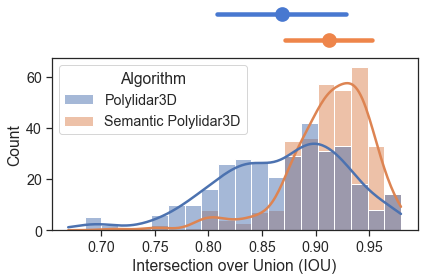

In [185]:
f, (ax_box_baseline, ax_box_new, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (0.075, 0.075, .85)})

g = sns.histplot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, ax=ax_hist, legend=True)

sns.pointplot(data=df_baseline, x="Intersection over Union (IOU)", ax=ax_box_baseline, color=palette[0], ci="sd")
sns.pointplot(data=df_new, x="Intersection over Union (IOU)", ax=ax_box_new, color=palette[1], ci="sd")
ax_box_baseline.axis('off')
ax_box_new.axis('off')
f.tight_layout()
f.savefig('../assets/imgs/compare_algs_extra_2.pdf')

In [195]:
## Cross Checking with the internal scipy function
from scipy import stats
t2, p2 = stats.ttest_ind(df_new['Intersection over Union (IOU)'], df_baseline['Intersection over Union (IOU)'], equal_var=True)
print("t = " + str(t2))
print("p = " + str(p2))

t = 10.994697953086854
p = 6.420177887053354e-26
